In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import gc
import json
import copy
import time
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 31.8 s, sys: 1.99 s, total: 33.8 s
Wall time: 31.8 s


In [6]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [7]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [8]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [9]:
train_df = train_df.rename({'event_code_title':'title_event_code'}, axis='columns')
test_df = test_df.rename({'event_code_title':'title_event_code'}, axis='columns')

In [10]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [11]:
comp_train_df = feature_engineering.feature_generation_2(train_samples, False, assess_titles=assess_titles,
                                                         list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
                                                         activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
                                                         win_code=win_code,
                                                         activities_map=activities_map)

In [12]:
extra_training = []
comp_test_df = feature_engineering.feature_generation_2(test_samples, True, assess_titles=assess_titles,
                                                         list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
                                                         activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
                                                         win_code=win_code,
                                                         activities_map=activities_map,
                                                         extra_training=extra_training,
                                                         include_all=True)

In [13]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,06372577,250513af,bfc77bd6,00c73085,de26c3a6,1bb5fbdb,b7530680,4d911100,1575e76c,15f99afc,3dcdda7f,65abac75,4ef8cdd3,13f56524,392e14df,3bf1cf26,ecc6157f,0d18d96c,67aa2ada,3ee399c3,262136f4,8fee50e2,3bfd1a65,f32856e4,05ad839b,736f9581,763fc34e,4901243f,f54238ee,e37a2b78,f6947f54,37c53127,3bb91ced,4e5fc6f5,ad148f58,9d4e7b25,3a4be871,90d848e0,a8efe47b,a8876db3,93edfe2e,99ea62f3,2c4e6db0,a16a373e,8d748b58,ea321fb1,86ba578b,c0415e5c,8d7e386c,8d84fa81,119b5b02,55115cbd,363d3849,828e68f9,44cb4907,37937459,30df3273,28520915,a5be6304,b012cd7f,71fe8f75,56bcd38d,461eace6,565a3990,e694a35b,46b50ba8,9e34ea74,16dffff1,7d093bf9,ab3136ba,cf7638f3,a29c5338,17ca3959,bc8f2793,857f21c0,1beb320a,6077cc36,86c924c4,36fa3ebe,b2dba42b,1996c610,3dfd4aa4,e9c52111,31973d56,d88ca108,c6971acf,2dc29e21,f806dc10,c189aaf2,3d63345e,4d6737eb,795e4a37,884228c8,f28c589a,9554a50b,eb2c19cd,e7e44842,85de926c,92687c59,77261ab5,1375ccb7,832735e1,b7dc8128,16667cc5,85d1b0de,29a42aea,bbfe0445,45d01abe,ecaab346,4a4c3d21,84538528,dcb55a27,f71c4741,d2659ab4,d2278a3b,2230fab4,804ee27f,160654fd,9e4c8c7b,e3ff61fb,e080a381,0ce40006,bcceccc6,5c3d2b2f,0db6d71d,acf5c23f,6cf7d25c,3afb49e6,709b1251,0a08139c,ea296733,9b23e8ee,2fb91ec1,ca11f653,77c76bc5,ec138c1c,a6d66e51,6088b756,c2baf0bd,d06f75b5,0d1da71f,01ca3a3c,49ed92e9,5e109ec3,611485c5,1340b8d7,5e812b27,6f445b57,9d29771f,51311d7a,ab4ec3a4,bd701df8,7dfe6d8a,f7e47413,c51d8688,756e5507,0330ab6a,cb1178ad,a44b10dc,363c86c9,c74f40cd,9b4001e4,5154fc30,a1bbe385,dcaede90,3edf6747,8ac7cce4,b88f38da,17113b36,9e6b7fb5,cc5087a3,c1cac9a2,6c517a88,6bf9e3e1,28a4eb9a,67439901,cfbd47c8,923afab1,28f975ea,47026d5f,a52b92d5,5e3ea25a,e64e2cfd,b80e5e84,9ed8f6da,c952eb01,562cec5f,2a444e03,4b5efe37,1c178d24,a0faea5d,b74258a0,e7561dd2,51102b85,a7640a16,4bb2f698,2ec694de,58a0de5c,a76029ee,...,2080Bubble Bath,4100Cauldron Filler (Assessment),2000Ordering Spheres,4010Crystals Rule,3120Chest Sorter (Assessment),4080Pan Balance,4095Happy Camel,4090Scrub-A-Dub,4040Happy Camel,4030All Star Sorting,4070Dino Dive,3021Scrub-A-Dub,2070Dino Drink,3010Happy Camel,4090Chest Sorter (Assessment),4035All Star Sorting,4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),3010Scrub-A-Dub,4070Chest Sorter (Assessment),4030Bug Measurer (Activity),4040Chest Sorter (Assessment),2000Cart Balancer (Assessment),3110Watering Hole (Activity),3010Bug Measurer (Activity),4080Sandcastle Builder (Activity),4025Mushroom Sorter (Assessment),4100Chest Sorter (Assessment),4030Happy Camel,4020All Star Sorting,4020Mushroom Sorter (Assessment),2000Watering Hole (Activity),4030Sandcastle Builder (Activity),2030Dino Dive,2030Happy Camel,4035Cauldron Filler (Assessment),3110Dino Dive,4035Chest Sorter (Assessment),2010Watering Hole (Activity),4010Bubble Bath,4035Chicken Balancer (Activity),4025Chest Sorter (Assessment),4080Egg Dropper (Activity),4080Fireworks (Activity),3120Happy Camel,3120Crystals Rule,2000Cauldron Filler (Assessment),2000Welcome to Lost Lagoon!,4021Watering Hole (Activity),4090Flower Waterer (Activity),2030Chow Time,2020Mushroom Sorter (Assessment),3020Pan Balance,4100Cart Balancer (Assessment),2010Cauldron Filler (Assessment),4030Bottle Filler (Activity),3020Bird Measurer (Assessment),2025Mushroom Sorter (Assessment),4035Mushroom Sorter (Assessment),3010Chest Sorter (Assessment),3021Dino Drink,4095Leaf Leader,4090Bubble Bath,3120Chow Time,3121Cart Balancer (Assessment),3020Cart Balancer (Assessment),4030Chow Time,4090Happy Camel,4080Bottle Filler (Activity),4090Sandcastle Builder (Activity),2000Honey Cake,2020Pan Balance,4020Chicken Balancer (Activity),3021Bird Measurer (As

In [14]:
comp_test_df

,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,06372577,250513af,bfc77bd6,00c73085,de26c3a6,1bb5fbdb,b7530680,4d911100,1575e76c,15f99afc,3dcdda7f,65abac75,4ef8cdd3,13f56524,392e14df,3bf1cf26,ecc6157f,0d18d96c,67aa2ada,3ee399c3,262136f4,8fee50e2,3bfd1a65,f32856e4,05ad839b,736f9581,763fc34e,4901243f,f54238ee,e37a2b78,f6947f54,37c53127,3bb91ced,4e5fc6f5,ad148f58,9d4e7b25,3a4be871,90d848e0,a8efe47b,a8876db3,93edfe2e,99ea62f3,2c4e6db0,a16a373e,8d748b58,ea321fb1,86ba578b,c0415e5c,8d7e386c,8d84fa81,119b5b02,55115cbd,363d3849,828e68f9,44cb4907,37937459,30df3273,28520915,a5be6304,b012cd7f,71fe8f75,56bcd38d,461eace6,565a3990,e694a35b,46b50ba8,9e34ea74,16dffff1,7d093bf9,ab3136ba,cf7638f3,a29c5338,17ca3959,bc8f2793,857f21c0,1beb320a,6077cc36,86c924c4,36fa3ebe,b2dba42b,1996c610,3dfd4aa4,e9c52111,31973d56,d88ca108,c6971acf,2dc29e21,f806dc10,c189aaf2,3d63345e,4d6737eb,795e4a37,884228c8,f28c589a,9554a50b,eb2c19cd,e7e44842,85de926c,92687c59,77261ab5,1375ccb7,832735e1,b7dc8128,16667cc5,85d1b0de,29a42aea,bbfe0445,45d01abe,ecaab346,4a4c3d21,84538528,dcb55a27,f71c4741,d2659ab4,d2278a3b,2230fab4,804ee27f,160654fd,9e4c8c7b,e3ff61fb,e080a381,0ce40006,bcceccc6,5c3d2b2f,0db6d71d,acf5c23f,6cf7d25c,3afb49e6,709b1251,0a08139c,ea296733,9b23e8ee,2fb91ec1,ca11f653,77c76bc5,ec138c1c,a6d66e51,6088b756,c2baf0bd,d06f75b5,0d1da71f,01ca3a3c,49ed92e9,5e109ec3,611485c5,1340b8d7,5e812b27,6f445b57,9d29771f,51311d7a,ab4ec3a4,bd701df8,7dfe6d8a,f7e47413,c51d8688,756e5507,0330ab6a,cb1178ad,a44b10dc,363c86c9,c74f40cd,9b4001e4,5154fc30,a1bbe385,dcaede90,3edf6747,8ac7cce4,b88f38da,17113b36,9e6b7fb5,cc5087a3,c1cac9a2,6c517a88,6bf9e3e1,28a4eb9a,67439901,cfbd47c8,923afab1,28f975ea,47026d5f,a52b92d5,5e3ea25a,e64e2cfd,b80e5e84,9ed8f6da,c952eb01,562cec5f,2a444e03,4b5efe37,1c178d24,a0faea5d,b74258a0,e7561dd2,51102b85,a7640a16,4bb2f698,2ec694de,58a0de5c,a76029ee,...,2080Bubble Bath,4100Cauldron Filler (Assessment),2000Ordering Spheres,4010Crystals Rule,3120Chest Sorter (Assessment),4080Pan Balance,4095Happy Camel,4090Scrub-A-Dub,4040Happy Camel,4030All Star Sorting,4070Dino Dive,3021Scrub-A-Dub,2070Dino Drink,3010Happy Camel,4090Chest Sorter (Assessment),4035All Star Sorting,4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),3010Scrub-A-Dub,4070Chest Sorter (Assessment),4030Bug Measurer (Activity),4040Chest Sorter (Assessment),2000Cart Balancer (Assessment),3110Watering Hole (Activity),3010Bug Measurer (Activity),4080Sandcastle Builder (Activity),4025Mushroom Sorter (Assessment),4100Chest Sorter (Assessment),4030Happy Camel,4020All Star Sorting,4020Mushroom Sorter (Assessment),2000Watering Hole (Activity),4030Sandcastle Builder (Activity),2030Dino Dive,2030Happy Camel,4035Cauldron Filler (Assessment),3110Dino Dive,4035Chest Sorter (Assessment),2010Watering Hole (Activity),4010Bubble Bath,4035Chicken Balancer (Activity),4025Chest Sorter (Assessment),4080Egg Dropper (Activity),4080Fireworks (Activity),3120Happy Camel,3120Crystals Rule,2000Cauldron Filler (Assessment),2000Welcome to Lost Lagoon!,4021Watering Hole (Activity),4090Flower Waterer (Activity),2030Chow Time,2020Mushroom Sorter (Assessment),3020Pan Balance,4100Cart Balancer (Assessment),2010Cauldron Filler (Assessment),4030Bottle Filler (Activity),3020Bird Measurer (Assessment),2025Mushroom Sorter (Assessment),4035Mushroom Sorter (Assessment),3010Chest Sorter (Assessment),3021Dino Drink,4095Leaf Leader,4090Bubble Bath,3120Chow Time,3121Cart Balancer (Assessment),3020Cart Balancer (Assessment),4030Chow Time,4090Happy Camel,4080Bottle Filler (Activity),4090Sandcastle Builder (Activity),2000Honey Cake,2020Pan Balance,4020Chicken Balancer (Activity),3021Bird Measurer (As

In [15]:
comp_train_df, comp_test_df = feature_engineering.preprocess(comp_train_df, comp_test_df)

In [16]:
comp_test_df = comp_test_df.groupby(['installation_id']).last().reset_index()

In [17]:
comp_test_df

,installation_id,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,06372577,250513af,bfc77bd6,00c73085,de26c3a6,1bb5fbdb,b7530680,4d911100,1575e76c,15f99afc,3dcdda7f,65abac75,4ef8cdd3,13f56524,392e14df,3bf1cf26,ecc6157f,0d18d96c,67aa2ada,3ee399c3,262136f4,8fee50e2,3bfd1a65,f32856e4,05ad839b,736f9581,763fc34e,4901243f,f54238ee,e37a2b78,f6947f54,37c53127,3bb91ced,4e5fc6f5,ad148f58,9d4e7b25,3a4be871,90d848e0,a8efe47b,a8876db3,93edfe2e,99ea62f3,2c4e6db0,a16a373e,8d748b58,ea321fb1,86ba578b,c0415e5c,8d7e386c,8d84fa81,119b5b02,55115cbd,363d3849,828e68f9,44cb4907,37937459,30df3273,28520915,a5be6304,b012cd7f,71fe8f75,56bcd38d,461eace6,565a3990,e694a35b,46b50ba8,9e34ea74,16dffff1,7d093bf9,ab3136ba,cf7638f3,a29c5338,17ca3959,bc8f2793,857f21c0,1beb320a,6077cc36,86c924c4,36fa3ebe,b2dba42b,1996c610,3dfd4aa4,e9c52111,31973d56,d88ca108,c6971acf,2dc29e21,f806dc10,c189aaf2,3d63345e,4d6737eb,795e4a37,884228c8,f28c589a,9554a50b,eb2c19cd,e7e44842,85de926c,92687c59,77261ab5,1375ccb7,832735e1,b7dc8128,16667cc5,85d1b0de,29a42aea,bbfe0445,45d01abe,ecaab346,4a4c3d21,84538528,dcb55a27,f71c4741,d2659ab4,d2278a3b,2230fab4,804ee27f,160654fd,9e4c8c7b,e3ff61fb,e080a381,0ce40006,bcceccc6,5c3d2b2f,0db6d71d,acf5c23f,6cf7d25c,3afb49e6,709b1251,0a08139c,ea296733,9b23e8ee,2fb91ec1,ca11f653,77c76bc5,ec138c1c,a6d66e51,6088b756,c2baf0bd,d06f75b5,0d1da71f,01ca3a3c,49ed92e9,5e109ec3,611485c5,1340b8d7,5e812b27,6f445b57,9d29771f,51311d7a,ab4ec3a4,bd701df8,7dfe6d8a,f7e47413,c51d8688,756e5507,0330ab6a,cb1178ad,a44b10dc,363c86c9,c74f40cd,9b4001e4,5154fc30,a1bbe385,dcaede90,3edf6747,8ac7cce4,b88f38da,17113b36,9e6b7fb5,cc5087a3,c1cac9a2,6c517a88,6bf9e3e1,28a4eb9a,67439901,cfbd47c8,923afab1,28f975ea,47026d5f,a52b92d5,5e3ea25a,e64e2cfd,b80e5e84,9ed8f6da,c952eb01,562cec5f,2a444e03,4b5efe37,1c178d24,a0faea5d,b74258a0,e7561dd2,51102b85,a7640a16,4bb2f698,2ec694de,58a0de5c,...,4010Crystals Rule,3120Chest Sorter (Assessment),4080Pan Balance,4095Happy Camel,4090Scrub-A-Dub,4040Happy Camel,4030All Star Sorting,4070Dino Dive,3021Scrub-A-Dub,2070Dino Drink,3010Happy Camel,4090Chest Sorter (Assessment),4035All Star Sorting,4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),3010Scrub-A-Dub,4070Chest Sorter (Assessment),4030Bug Measurer (Activity),4040Chest Sorter (Assessment),2000Cart Balancer (Assessment),3110Watering Hole (Activity),3010Bug Measurer (Activity),4080Sandcastle Builder (Activity),4025Mushroom Sorter (Assessment),4100Chest Sorter (Assessment),4030Happy Camel,4020All Star Sorting,4020Mushroom Sorter (Assessment),2000Watering Hole (Activity),4030Sandcastle Builder (Activity),2030Dino Dive,2030Happy Camel,4035Cauldron Filler (Assessment),3110Dino Dive,4035Chest Sorter (Assessment),2010Watering Hole (Activity),4010Bubble Bath,4035Chicken Balancer (Activity),4025Chest Sorter (Assessment),4080Egg Dropper (Activity),4080Fireworks (Activity),3120Happy Camel,3120Crystals Rule,2000Cauldron Filler (Assessment),2000Welcome to Lost Lagoon!,4021Watering Hole (Activity),4090Flower Waterer (Activity),2030Chow Time,2020Mushroom Sorter (Assessment),3020Pan Balance,4100Cart Balancer (Assessment),2010Cauldron Filler (Assessment),4030Bottle Filler (Activity),3020Bird Measurer (Assessment),2025Mushroom Sorter (Assessment),4035Mushroom Sorter (Assessment),3010Chest Sorter (Assessment),3021Dino Drink,4095Leaf Leader,4090Bubble Bath,3120Chow Time,3121Cart Balancer (Assessment),3020Cart Balancer (Assessment),4030Chow Time,4090Happy Camel,4080Bottle Filler (Activity),4090Sandcastle Builder (Activity),2000Honey Cake,2020Pan Balance,4020Chicken Balancer (Activity),3021Bird Measurer (Assessment),4020Leaf Leader,4070Happy Camel,3110Pan Balance,2020E

### Remove zero columns

In [18]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

In [19]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,06372577,250513af,bfc77bd6,00c73085,de26c3a6,1bb5fbdb,b7530680,4d911100,1575e76c,15f99afc,3dcdda7f,65abac75,4ef8cdd3,13f56524,392e14df,3bf1cf26,ecc6157f,0d18d96c,67aa2ada,3ee399c3,262136f4,8fee50e2,3bfd1a65,f32856e4,05ad839b,736f9581,763fc34e,4901243f,f54238ee,e37a2b78,f6947f54,37c53127,3bb91ced,4e5fc6f5,ad148f58,9d4e7b25,3a4be871,90d848e0,a8efe47b,a8876db3,93edfe2e,99ea62f3,2c4e6db0,a16a373e,8d748b58,ea321fb1,86ba578b,c0415e5c,8d7e386c,8d84fa81,119b5b02,55115cbd,363d3849,828e68f9,44cb4907,37937459,30df3273,28520915,a5be6304,b012cd7f,71fe8f75,56bcd38d,461eace6,565a3990,e694a35b,46b50ba8,9e34ea74,16dffff1,7d093bf9,ab3136ba,cf7638f3,a29c5338,bc8f2793,857f21c0,1beb320a,6077cc36,86c924c4,36fa3ebe,b2dba42b,1996c610,3dfd4aa4,e9c52111,31973d56,d88ca108,c6971acf,2dc29e21,f806dc10,c189aaf2,3d63345e,4d6737eb,795e4a37,884228c8,f28c589a,9554a50b,eb2c19cd,e7e44842,85de926c,92687c59,77261ab5,1375ccb7,832735e1,b7dc8128,16667cc5,85d1b0de,29a42aea,bbfe0445,45d01abe,ecaab346,4a4c3d21,84538528,dcb55a27,f71c4741,d2659ab4,d2278a3b,2230fab4,804ee27f,160654fd,9e4c8c7b,e3ff61fb,e080a381,0ce40006,bcceccc6,5c3d2b2f,0db6d71d,acf5c23f,6cf7d25c,3afb49e6,709b1251,0a08139c,ea296733,9b23e8ee,2fb91ec1,ca11f653,77c76bc5,ec138c1c,a6d66e51,6088b756,c2baf0bd,d06f75b5,0d1da71f,01ca3a3c,49ed92e9,5e109ec3,611485c5,1340b8d7,5e812b27,6f445b57,9d29771f,51311d7a,ab4ec3a4,bd701df8,7dfe6d8a,f7e47413,c51d8688,756e5507,0330ab6a,cb1178ad,a44b10dc,363c86c9,c74f40cd,9b4001e4,5154fc30,a1bbe385,dcaede90,3edf6747,8ac7cce4,b88f38da,17113b36,9e6b7fb5,cc5087a3,c1cac9a2,6c517a88,6bf9e3e1,28a4eb9a,67439901,cfbd47c8,923afab1,28f975ea,47026d5f,a52b92d5,5e3ea25a,e64e2cfd,b80e5e84,9ed8f6da,c952eb01,562cec5f,2a444e03,4b5efe37,1c178d24,a0faea5d,b74258a0,e7561dd2,51102b85,a7640a16,4bb2f698,2ec694de,58a0de5c,a76029ee,47efca07,...,4100Cauldron Filler (Assessment),2000Ordering Spheres,4010Crystals Rule,3120Chest Sorter (Assessment),4080Pan Balance,4095Happy Camel,4090Scrub-A-Dub,4040Happy Camel,4030All Star Sorting,4070Dino Dive,3021Scrub-A-Dub,2070Dino Drink,3010Happy Camel,4090Chest Sorter (Assessment),4035All Star Sorting,4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),3010Scrub-A-Dub,4070Chest Sorter (Assessment),4030Bug Measurer (Activity),4040Chest Sorter (Assessment),2000Cart Balancer (Assessment),3110Watering Hole (Activity),3010Bug Measurer (Activity),4080Sandcastle Builder (Activity),4025Mushroom Sorter (Assessment),4100Chest Sorter (Assessment),4030Happy Camel,4020All Star Sorting,4020Mushroom Sorter (Assessment),2000Watering Hole (Activity),4030Sandcastle Builder (Activity),2030Dino Dive,2030Happy Camel,4035Cauldron Filler (Assessment),3110Dino Dive,4035Chest Sorter (Assessment),2010Watering Hole (Activity),4010Bubble Bath,4035Chicken Balancer (Activity),4025Chest Sorter (Assessment),4080Egg Dropper (Activity),4080Fireworks (Activity),3120Happy Camel,3120Crystals Rule,2000Cauldron Filler (Assessment),2000Welcome to Lost Lagoon!,4021Watering Hole (Activity),4090Flower Waterer (Activity),2030Chow Time,2020Mushroom Sorter (Assessment),3020Pan Balance,4100Cart Balancer (Assessment),2010Cauldron Filler (Assessment),4030Bottle Filler (Activity),3020Bird Measurer (Assessment),2025Mushroom Sorter (Assessment),4035Mushroom Sorter (Assessment),3010Chest Sorter (Assessment),3021Dino Drink,4095Leaf Leader,4090Bubble Bath,3120Chow Time,3121Cart Balancer (Assessment),3020Cart Balancer (Assessment),4030Chow Time,4090Happy Camel,4080Bottle Filler (Activity),4090Sandcastle Builder (Activity),2000Honey Cake,2020Pan Balance,4020Chicken Balancer (Activity),3021Bird Measurer (Assessment),4020Le

## Normalize Column Titles

In [20]:
import re

comp_train_df.columns = [c if type(c) != tuple else '_'.join(c) for c in comp_train_df.columns]
comp_test_df.columns = [c if type(c) != tuple else '_'.join(c) for c in comp_test_df.columns]
comp_train_df.columns = [re.sub(r'\W', '_', str(s)) for s in comp_train_df.columns]
comp_test_df.columns = [re.sub(r'\W', '_', str(s)) for s in comp_test_df.columns]

## Training

In [21]:
# grab the last assessments per id
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
len(valid_idx), comp_train_df.shape

(3614, (17690, 882))

In [22]:
# create a tran an validation data set
valid_ds = comp_train_df.iloc[valid_idx]
train_ds = comp_train_df.loc[~comp_train_df.index.isin(valid_idx)]

In [23]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100,
            'eval_metric': 'cappa',
            'cat_cols': ['session_title']
            }

In [24]:
def convert_regr_to_cat(y_pred):
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    convert_regr_to_cat(y_pred)

    return 'cappa', qwk(y_true, y_pred), True

In [25]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

In [26]:
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

In [27]:
dependent_var = 'accuracy_group'
X_train = train_ds[[c for c in train_ds.columns if c != dependent_var]]
y_train = train_ds['accuracy_group']
X_valid = valid_ds[[c for c in valid_ds.columns if c != dependent_var]]
y_valid = valid_ds['accuracy_group']

In [28]:
cols_to_drop = ['installation_id', 'accuracy']

def drop_columns(datasets, cols_to_drop):
    for ds in datasets:
        ds.drop(cols_to_drop, axis=1, inplace=True)

drop_columns([X_train, X_valid], cols_to_drop)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
regressor_model = LGBWrapper_regr()

In [30]:
regressor_model.fit(X_train, y_train, X_valid, y_valid, params=params)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['session_title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.884577	train's cappa: 0.690092	valid's rmse: 1.07002	valid's cappa: 0.539064
[200]	train's rmse: 0.819189	train's cappa: 0.741015	valid's rmse: 1.062	valid's cappa: 0.547615
[300]	train's rmse: 0.771715	train's cappa: 0.779112	valid's rmse: 1.06038	valid's cappa: 0.549107
[400]	train's rmse: 0.731579	train's cappa: 0.806858	valid's rmse: 1.06237	valid's cappa: 0.549451
Early stopping, best iteration is:
[310]	train's rmse: 0.767258	train's cappa: 0.782337	valid's rmse: 1.05986	valid's cappa: 0.552021


## Inference

In [31]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [32]:
%%time
y = comp_train_df[dependent_var]
pr1 = regressor_model.predict(comp_train_df[[c for c in X_train.columns]])

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

CPU times: user 7.47 s, sys: 188 ms, total: 7.66 s
Wall time: 2.85 s


In [33]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.7340489131406737

In [34]:
pr1 = regressor_model.predict(comp_test_df[[c for c in X_train.columns]])
convert_regr_to_cat(pr1)

In [35]:
sample_submission_df = pd.read_csv(path/'sample_submission.csv')

In [36]:
sample_submission_df['accuracy_group'] = pr1.astype(int)
sample_submission_df.to_csv('submission.csv', index=False)

In [37]:
sample_submission_df.to_csv('submission.csv', index = False)

In [38]:
!head submission.csv

installation_id,accuracy_group
00abaee7,2
01242218,3
017c5718,3
01a44906,3
01bc6cb6,3
02256298,3
0267757a,2
027e7ce5,2
02a29f99,0


## Data Checks

In [39]:
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
valid_ds = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy']
expected_ratios = valid_ds.apply(lambda x : feature_engineering.convert_to_accuracy_group(x)).value_counts(normalize=True)
expected_ratios

3    0.450747
0    0.283066
1    0.137244
2    0.128943
Name: accuracy, dtype: float64

In [40]:
pred_ratios = sample_submission_df['accuracy_group'].value_counts(normalize=True)
pred_ratios

3    0.493
2    0.203
0    0.160
1    0.144
Name: accuracy_group, dtype: float64

In [41]:
pred_ratios_list = np.array(pred_ratios.sort_index().tolist())
expected_ratios_list = np.array(expected_ratios.sort_index().tolist())
pred_ratios_list, expected_ratios_list

(array([0.16 , 0.144, 0.203, 0.493]),
 array([0.28306586, 0.13724405, 0.128943  , 0.45074709]))

In [42]:
prod = ((pred_ratios_list - pred_ratios_list.mean()) * (expected_ratios_list - expected_ratios_list.mean())).mean() / (pred_ratios_list.std() * expected_ratios_list.std())
prod

0.8522954099293584

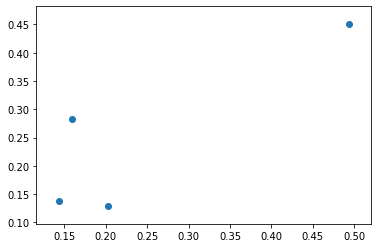

In [43]:
plt.scatter(pred_ratios_list, expected_ratios_list);